# Data Quality
## Setup

In [1]:
library(DBI)
library(RMySQL)
library(tidyverse)
library(dbplyr)

Loading tidyverse: ggplot2
Loading tidyverse: tibble
Loading tidyverse: tidyr
Loading tidyverse: readr
Loading tidyverse: purrr
Loading tidyverse: dplyr
Conflicts with tidy packages ---------------------------------------------------
filter(): dplyr, stats
lag():    dplyr, stats

Attaching package: ‘dbplyr’

The following objects are masked from ‘package:dplyr’:

    ident, sql



## Read in data

In [2]:
mimic.db <- dbConnect( RMySQL::MySQL(), host="mysql", port=3306
                     , user="jovyan", password="jovyan", dbname="mimic2"
                     )

In [3]:
dbListTables(mimic.db)

[1] "a_chartdurations"    "a_iodurations"       "a_meddurations"     
 [4] "additives"           "admissions"          "censusevents"       
 [7] "chartevents"         "comorbidity_scores"  "d_caregivers"       
[10] "d_careunits"         "d_chartitems"        "d_chartitems_detail"
[13] "d_codeditems"        "d_demographicitems"  "d_ioitems"          
[16] "d_labitems"          "d_meditems"          "d_parammap_items"   
[19] "d_patients"          "db_schema"           "deliveries"         
[22] "demographic_detail"  "demographicevents"   "drgevents"          
[25] "icd9"                "icustay_days"        "icustay_detail"     
[28] "icustayevents"       "ioevents"            "labevents"          
[31] "medevents"           "microbiologyevents"  "noteevents"         
[34] "parameter_mapping"   "poe_med"             "poe_order"          
[37] "procedureevents"     "totalbalevents"

In [4]:
# The patients table
patients   <- tbl(mimic.db, "d_patients")
# Admissions
admissions <- tbl(mimic.db, "admissions")
# ICU Stays
icustays   <- tbl(mimic.db, "icustayevents")
# Notes
noteevents <- tbl(mimic.db, 'noteevents')
# Care givers
caregivers <- tbl(mimic.db, 'd_caregivers')
# icd9 Diagnoses
icd9       <- tbl(mimic.db, 'icd9')

In [5]:
glimpse(patients)

Observations: 25
Variables: 5
$ subject_id          <int> 56, 3, 21, 12, 26, 37, 31, 61, 78, 67, 83, 117,...
$ sex                 <chr> "F", "M", "M", "M", "M", "M", "M", "M", "M", "M...
$ dob                 <chr> "2553-05-26 00:00:00", "2606-02-28 00:00:00", "...
$ dod                 <chr> "2644-01-23 00:00:00", "2683-05-02 00:00:00", "...
$ hospital_expire_flg <chr> "Y", "N", "Y", "Y", "N", "N", "Y", "Y", "N", "Y...


**NOTE:**  
With glimpse using remote(dbi) tables do not trust the observations number that is not correct. For example,

In [6]:
count(patients)

# Source:   lazy query [?? x 1]
# Database: mysql 5.7.12 [jovyan@mysql:/mimic2]
      n
  <dbl>
1  4000

the patients table has 4000 patients, so in the rest of this and when using your own we only pay attention to observations if it is less than 25.

## Check the data

In [7]:
patients %>% count(sex, hospital_expire_flg)

# Source:   lazy query [?? x 3]
# Database: mysql 5.7.12 [jovyan@mysql:/mimic2]
# Groups:   sex
    sex hospital_expire_flg     n
  <chr>               <chr> <dbl>
1  <NA>                   N    10
2  <NA>                   Y     3
3     F                   N  1047
4     F                   Y   809
5     M                   N  1290
6     M                   Y   841

Investigate the patients with missing sex

In [8]:
patients %>%                #< Using patients data,
    filter(is.na(sex)) %>%  #< filter to those missing sex,
    print(n=14)             #< and print everything.


# Source:   lazy query [?? x 5]
# Database: mysql 5.7.12 [jovyan@mysql:/mimic2]
   subject_id   sex                 dob                 dod hospital_expire_flg
        <int> <chr>               <chr>               <chr>               <chr>
 1       1659  <NA> 3099-07-04 00:00:00 3182-10-07 00:00:00                   N
 2       3520  <NA> 2627-09-29 00:00:00 2711-01-31 00:00:00                   N
 3       6625  <NA> 3195-12-28 00:00:00 3281-12-24 00:00:00                   N
 4       8187  <NA> 2767-04-15 00:00:00 2839-12-16 00:00:00                   N
 5      15556  <NA> 2929-04-23 00:00:00 3018-06-03 00:00:00                   N
 6      17056  <NA> 2897-01-05 00:00:00 2955-11-04 00:00:00                   N
 7      18841  <NA> 2468-06-28 00:00:00 2542-07-01 00:00:00                   Y
 8      20211  <NA> 2562-07-17 00:00:00 2621-02-21 00:00:00                   Y
 9      21684  <NA> 2853-04-06 00:00:00 2895-11-03 00:00:00                   Y
10      22042  <NA> 3398-01-06 00:00:00 

That is hard to read so lets add age.  However age cannot be computed directly from the database.  It could be **if** `dob` and `dod` were stored as timestamp fields but as they are character strings we are *SOL* for operating on the database so we have to bring things local.

To convert to a local table we use the `collect` function.

In [9]:
library(lubridate)
age <- function(dob, to) {
    # There are faster ways to do this but this is the simplest.
    # the interval function will automatically convert dob  and to
    # into date variables if they are in an unambiguous format
    # such as "Y-M-D H:M:S".  
    # This conversion could be done explicitly with the function ymd_hms
    interval(dob, to)/dyears(1)
}
patients %>%
    filter(is.na(sex)) %>% 
    select(-sex) %>%                         #< drop sex because we know what it is (missing).
    collect %>%                               #< We have to convert the table to local to mutate,
    mutate(age = age(dob, dod)) %>%          #< then add age at death,
    arrange(hospital_expire_flg) %>%         #< and change the sorting order.
    print(n=14, width=Inf)                   #< expanded the width to show all the columns




Attaching package: ‘lubridate’

The following object is masked from ‘package:base’:

    date



# A tibble: 13 x 5
   subject_id                 dob                 dod hospital_expire_flg      age
        <int>               <chr>               <chr>               <chr>    <dbl>
 1       1659 3099-07-04 00:00:00 3182-10-07 00:00:00                   N 83.31507
 2       3520 2627-09-29 00:00:00 2711-01-31 00:00:00                   N 83.39452
 3       6625 3195-12-28 00:00:00 3281-12-24 00:00:00                   N 86.04932
 4       8187 2767-04-15 00:00:00 2839-12-16 00:00:00                   N 72.72055
 5      15556 2929-04-23 00:00:00 3018-06-03 00:00:00                   N 89.16986
 6      17056 2897-01-05 00:00:00 2955-11-04 00:00:00                   N 58.86575
 7      22042 3398-01-06 00:00:00 3463-11-30 00:00:00                   N 65.93973
 8      22917 2535-09-02 00:00:00 2620-07-07 00:00:00                   N 84.90137
 9      23919 2967-05-21 00:00:00 3021-10-04 00:00:00                   N 54.40822
10      26237 3149-01-15 00:00:00 3231-07-05 00:00:00               

Interesting that they are older but nothing to explain why sex is missing.
> ### Discussion
> * Is this an issue for the data?
> * How can we investigate this more?
> * How can we deal with it?

### Ploting data

we will use [ggplot2](https://cran.r-project.org/package=ggplot2) for all of our graphics. Since ggplot2 cannot deal with remote data we do have to convert our patients to a local table which we saw already but let's also do some cleanup while we are at it.

There should be no problem since there are only 4000 patients, but we should use caution when pulling down very large tables from SQL.

In [10]:
patients.tbl <- patients %>%
                    collect %>%                  #< convert to local
                    mutate( dob = ymd_hms(dob)  #< convert to a true date format
                          , dod = ymd_hms(dod)  #< for both birth and death
                          , age = age(dob, dod) #< age does not need to convert.
                          )

In [11]:
patients.tbl %>% glimpse

Observations: 4,000
Variables: 6
$ subject_id          <int> 56, 3, 21, 12, 26, 37, 31, 61, 78, 67, 83, 117,...
$ sex                 <chr> "F", "M", "M", "M", "M", "M", "M", "M", "M", "M...
$ dob                 <dttm> 2553-05-26, 2606-02-28, 3051-05-22, 2803-05-14...
$ dod                 <dttm> 2644-01-23, 2683-05-02, 3139-03-28, 2875-10-09...
$ hospital_expire_flg <chr> "Y", "N", "Y", "Y", "N", "N", "Y", "Y", "N", "Y...
$ age                 <dbl> 90.72055, 77.22466, 87.90685, 72.45479, 73.8602...


> ### Shortcut:
> [Here is a shortcut for you](../../view/using.R).
> The `using` function is a script that will both load multiple packages and install and load missing ones.

In [12]:
source("../using.R")
using(ggplot2, scales)

Loading required package: scales


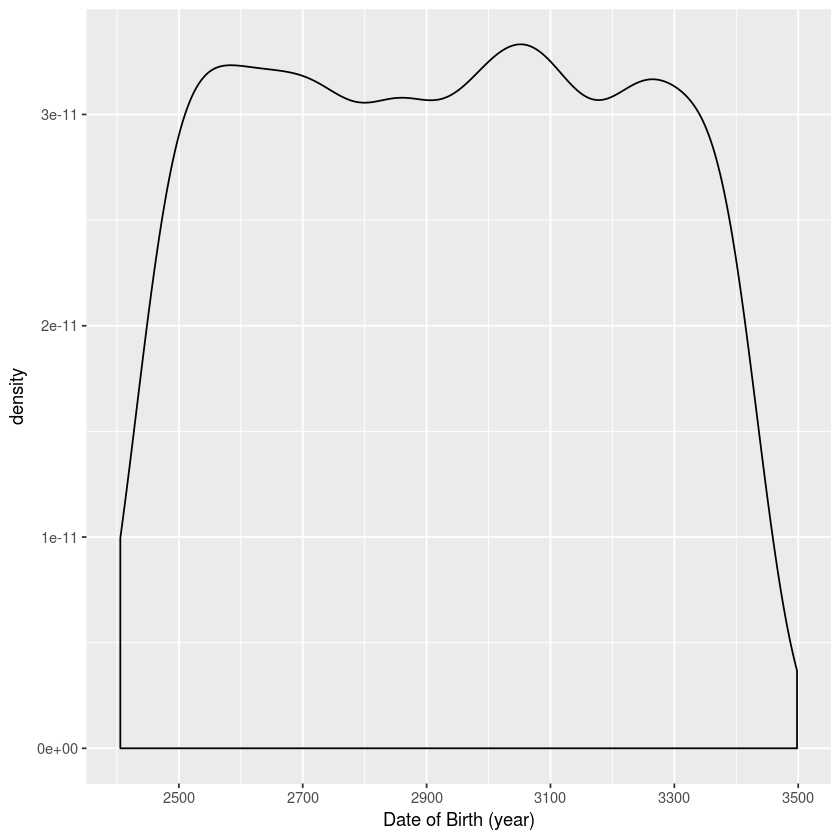

In [13]:
qplot( data=patients.tbl  #< use data patients.tbl, our local version
     , x=dob              #< the horizontal variable is Date of Birth
     , geom='density'     #< and we want a density geometry
     ) +
     labs(x='Date of Birth (year)')  #< change the label to make it cleaner.    

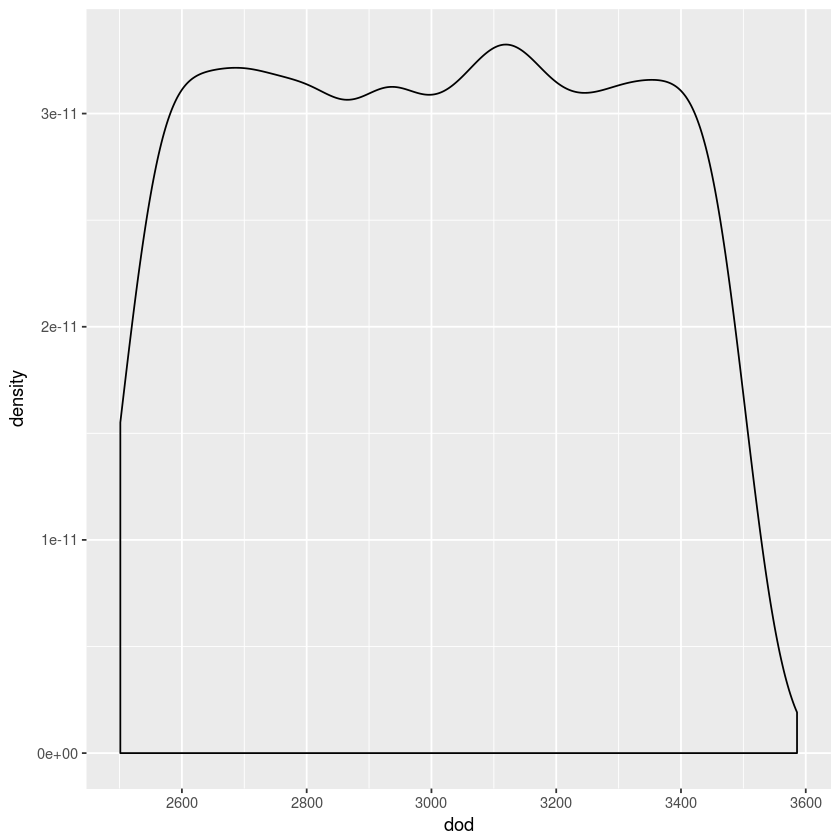

In [14]:
qplot(data=patients.tbl, x=dod, geom='density')

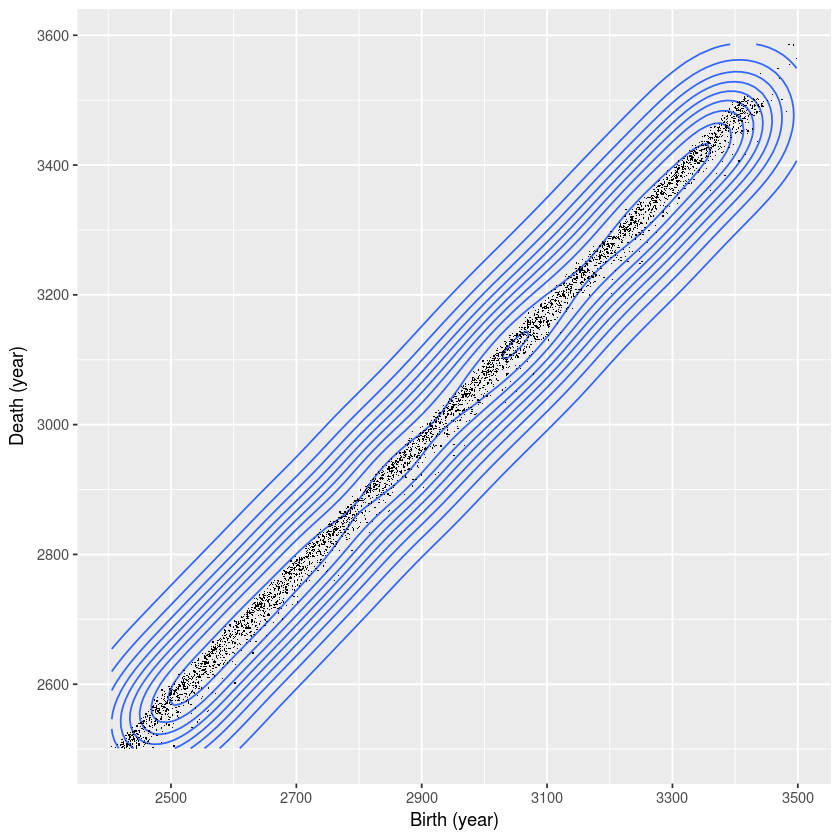

In [15]:
# this time we do a two dimensional plot
qplot(data=patients.tbl, x=dob, y=dod, geom='density2d') + 
    geom_point(alpha=1, shape='.') + 
    labs( x = "Birth (year)"
        , y = "Death (year)"
        )

**Takeaway:**  
Dates are clearly only relevent within patient.

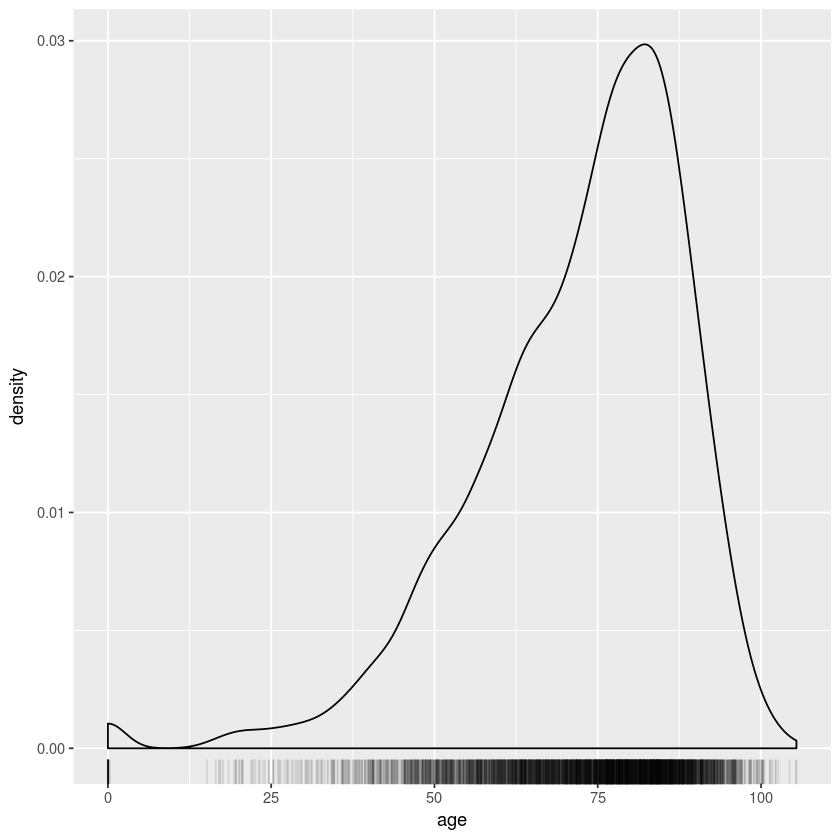

In [16]:
ggplot(patients.tbl, aes(x=age)) +
    geom_density() + 
    geom_rug(alpha=0.1)

In [17]:
quantile(patients.tbl$age)

0%       25%       50%       75%      100% 
  0.00000  63.19041  75.63836  84.01096 105.42192

In [18]:
using(magrittr)  # more pipes!
source("../percent.R")  # the format.percent helper function
patients.tbl %$% sum(age<10)
patients.tbl %>% 
    summarise( under_1_at_death.N   =  sum(age<1)
             , under_1_at_death.pct = mean(age<1) %>% format.percent()
             , still_alive = sum(is.na(dod))
             ) %>% 
    gather(name, value, everything()) #< this transposed the function for easier reading

Loading required package: magrittr


[1] 28

name,value
under_1_at_death.N,28
under_1_at_death.pct,0.70%
still_alive,0


In [19]:
patients.tbl %>% filter(age<10) %>% print(width=Inf)

# A tibble: 28 x 6
   subject_id   sex        dob        dod hospital_expire_flg         age
        <int> <chr>     <dttm>     <dttm>               <chr>       <dbl>
 1        517     F 2951-08-21 2951-12-16                   Y 0.320547945
 2       2532     M 2602-01-17 2602-01-20                   Y 0.008219178
 3       3071     M 3361-01-21 3361-01-29                   Y 0.021917808
 4       5757     F 2968-03-04 2968-03-11                   Y 0.019178082
 5       5889     F 3482-05-16 3482-05-17                   Y 0.002739726
 6       6532     M 3435-11-28 3435-11-29                   Y 0.002739726
 7       7370     F 2767-08-26 2767-08-27                   Y 0.002739726
 8       7832     F 2503-08-12 2503-08-12                   Y 0.000000000
 9       7919     F 3077-11-12 3077-12-04                   Y 0.060273973
10       7962     M 3383-12-11 3383-12-26                   Y 0.041095890
# ... with 18 more rows


### Demographics table

In [20]:
demographicevents <- tbl(mimic.db, 'demographicevents')
glimpse(demographicevents)

Observations: 25
Variables: 3
$ subject_id <int> 3, 3, 3, 3, 3, 3, 12, 12, 12, 12, 12, 12, 21, 21, 21, 21...
$ hadm_id    <int> 2075, 2075, 2075, 2075, 2075, 2075, 12532, 12532, 12532,...
$ itemid     <int> 200023, 200028, 200029, 200050, 200052, 200083, 200027, ...


In [21]:
d_demographicitems <- tbl(mimic.db, 'd_demographicitems')
glimpse(d_demographicitems)

Observations: 25
Variables: 3
$ itemid   <int> 200001, 200002, 200003, 200004, 200005, 200006, 200007, 20...
$ label    <chr> "** INFO NOT AVAILABLE **", "7TH DAY ADVENTIST", "AMERICAN...
$ category <chr> "ADMISSION SOURCE", "RELIGION", "ETHNICITY", "ETHNICITY", ...


In [22]:
count(d_demographicitems, category)

# Source:   lazy query [?? x 2]
# Database: mysql 5.7.12 [jovyan@mysql:/mimic2]
             category     n
                <chr> <dbl>
1    ADMISSION SOURCE     8
2      ADMISSION TYPE     4
3           ETHNICITY    41
4      MARITAL STATUS     7
5 OVERALL PAYOR GROUP     8
6            RELIGION    20

#### Ethnicity ####

In [23]:
ethnicity.tbl <- 
    d_demographicitems %>% filter(category == "ETHNICITY") %>%
    left_join(demographicevents) %>% 
    right_join(patients)
ethnicity.tbl %>% collect %>%
    count(label) %>%
    arrange(desc(n)) %>%
    mutate(pct = format.percent(n/sum(n)))

Joining, by = "itemid"
Joining, by = "subject_id"


label,n,pct
WHITE,3544,69.19%
UNKNOWN/NOT SPECIFIED,730,14.25%
BLACK/AFRICAN AMERICAN,474,9.25%
ASIAN,86,1.68%
OTHER,78,1.52%
HISPANIC OR LATINO,71,1.39%
PATIENT DECLINED TO ANSWER,52,1.02%
NA,48,0.94%
UNABLE TO OBTAIN,18,0.35%
ASIAN - CHINESE,5,0.10%


This is OK but really we should not have rows with small counts.

In [24]:
using(forcats)
ethnicity.tbl %>% collect %>%
    mutate(label = fct_recode( replace(label, is.na(label), "UNKNOWN/NOT SPECIFIED")
                             , "UNKNOWN/NOT SPECIFIED" = "PATIENT DECLINED TO ANSWER"
                             , "UNKNOWN/NOT SPECIFIED" = "UNABLE TO OBTAIN"
                             , "WHITE" = "WHITE - RUSSIAN"
                             , "ASIAN" = "ASIAN - VIETNAMESE"
                             , "ASIAN" = "ASIAN - CHINESE"
                             , "HISPANIC OR LATINO" = "HISPANIC/LATINO - PUERTO RICAN"
                             , "BLACK/AFRICAN AMERICAN" = "BLACK/CAPE VERDEAN"
                             , "BLACK/AFRICAN AMERICAN" = "BLACK/HAITIAN"
                             , "OTHER" = "AMERICAN INDIAN/ALASKA NATIVE"
                             , "OTHER" = "MULTI RACE ETHNICITY"
                             , "OTHER" = "NATIVE HAWAIIAN OR OTHER PACIFIC ISLAND"
                             )) %>%
    count(label) %>%
    arrange(desc(n)) %>%
    mutate(pct = format.percent(n/sum(n)))

Loading required package: forcats


label,n,pct
WHITE,3545,69.21%
UNKNOWN/NOT SPECIFIED,848,16.56%
BLACK/AFRICAN AMERICAN,478,9.33%
ASIAN,92,1.80%
OTHER,85,1.66%
HISPANIC OR LATINO,74,1.44%


We should check consistency of ethnicity.

In [25]:
ethnicity.tbl %>% select(subject_id, ethnicity=label) %>% distinct %>%
    count(subject_id) %>% ungroup %>%
    count(n)

# Source:   lazy query [?? x 2]
# Database: mysql 5.7.12 [jovyan@mysql:/mimic2]
      n    nn
  <dbl> <dbl>
1     1  3995
2     2     5

This is very common to have changing things like ethnicity that should not really every change.

In [26]:
ethnicity.tbl %>% select(subject_id, ethnicity=label) %>% distinct %>%
    count(subject_id) %>% ungroup  %>%
    filter(n>1) %>% 
    left_join(ethnicity.tbl)

Joining, by = "subject_id"


# Source:   lazy query [?? x 10]
# Database: mysql 5.7.12 [jovyan@mysql:/mimic2]
   subject_id     n itemid                          label  category hadm_id
        <int> <dbl>  <int>                          <chr>     <chr>   <int>
 1        426     2 200080          UNKNOWN/NOT SPECIFIED ETHNICITY    1638
 2        426     2 200083                          WHITE ETHNICITY    6410
 3       5882     2 200018         BLACK/AFRICAN AMERICAN ETHNICITY    6039
 4       5882     2 200083                          WHITE ETHNICITY    7770
 5       6283     2 200083                          WHITE ETHNICITY    8765
 6       6283     2 200080          UNKNOWN/NOT SPECIFIED ETHNICITY   15864
 7       8231     2 200035             HISPANIC OR LATINO ETHNICITY    5754
 8       8231     2 200035             HISPANIC OR LATINO ETHNICITY    7668
 9       8231     2 200035             HISPANIC OR LATINO ETHNICITY   13574
10       8231     2 200042 HISPANIC/LATINO - PUERTO RICAN ETHNICITY   23961
# ... w

Sure enough we have conflicting data.
> #### Discussion
> * Is this a problem?
> * How do we handle it?
> 
> *For the sake of argument pretend that there is more than one unresolvable issue.*

#### Marital Status ####

In [27]:
marital.tbl <- d_demographicitems %>% 
    filter(category == "MARITAL STATUS") %>%
    left_join(demographicevents) %>% 
    right_join(patients) 
marital.tbl %>%
    count(label)

Joining, by = "itemid"
Joining, by = "subject_id"


# Source:   lazy query [?? x 2]
# Database: mysql 5.7.12 [jovyan@mysql:/mimic2]
              label     n
              <chr> <dbl>
1              <NA>   403
2          DIVORCED   276
3           MARRIED  2315
4         SEPARATED    54
5            SINGLE   925
6 UNKNOWN (DEFAULT)    61
7           WIDOWED  1068

In [28]:
marital.tbl %>% 
    select(subject_id, label) %>% distinct %>%
    count(subject_id) %>% ungroup %>%
    count(n)

# Source:   lazy query [?? x 2]
# Database: mysql 5.7.12 [jovyan@mysql:/mimic2]
      n    nn
  <dbl> <dbl>
1     1  3996
2     2     4

Note that demographics is indexed on `hadm_id`, the admission id, thus we would expect that 
marital status **can** evolve over time.

In [29]:
marital.tbl %>% 
    select(subject_id, label) %>% distinct %>%
    count(subject_id) %>% 
    filter(n>1) %>% select(-n) %>%
    left_join(admissions) %>% 
    left_join(marital.tbl) %>%
    left_join(patients) %>%
    collect %>%
    mutate(age_at_admit = age(dob, admit_dt)) %>%
    select(subject_id, sex, admit_dt, age_at_admit, marital_status=label)

Joining, by = "subject_id"
Joining, by = c("subject_id", "hadm_id")
Joining, by = c("subject_id", "sex", "dob", "dod", "hospital_expire_flg")


subject_id,sex,admit_dt,age_at_admit,marital_status
5882,M,3225-10-02 00:00:00,58.79178,DIVORCED
5882,M,3226-03-12 00:00:00,59.23288,MARRIED
8231,F,3205-06-12 00:00:00,72.37534,SEPARATED
8231,F,3207-01-10 00:00:00,73.95616,WIDOWED
8231,F,3207-12-23 00:00:00,74.90685,WIDOWED
8231,F,3208-02-10 00:00:00,75.04110,WIDOWED
8231,F,3209-01-13 00:00:00,75.96712,WIDOWED
8231,F,3210-07-15 00:00:00,77.46849,WIDOWED
8896,M,3417-05-12 00:00:00,70.23288,SINGLE
8896,M,3420-03-22 00:00:00,73.09589,WIDOWED


### Chart events table

Here is a little helpful utility that we will use to find things

In [30]:
sift <- 
function( x                 #< A character vector 
        , pat               #< Regular expression pattern
        , value=TRUE        #< Return value or indices.
        , perl=TRUE         #< is `pat` perl compatible?
        , ignore.case=TRUE  #< Should case be ignored?
        , ...               #< passed on to <grep>
        ){
    #' Pipe compatible regular expression filtering.
    unique(grep( pattern=pat, x=x
               , value=value, ignore.case=ignore.case, perl=perl
               , ...))
    #' @seealso <grep>.
    #' @return A subset of x vector that matches the pattern given in `pat`.
}

In [31]:
dbListTables(mimic.db) %>% sift('chart')  #< lists the chart related tables

[1] "a_chartdurations"    "chartevents"         "d_chartitems"       
[4] "d_chartitems_detail"

Also lets make things a little shorter, because I'm *lazy* 😉

In [32]:
tbl <- purrr::partial(dplyr::tbl, src=mimic.db)

In [33]:
previous <- ls()
needed.tbls <- dbListTables(mimic.db) %>% setdiff(ls())
for(tb in needed.tbls) assign(tb, tbl(tb))
setdiff(ls(), previous)
rm(previous, tb)

[1] "a_chartdurations"    "a_iodurations"       "a_meddurations"     
 [4] "additives"           "censusevents"        "chartevents"        
 [7] "comorbidity_scores"  "d_caregivers"        "d_careunits"        
[10] "d_chartitems"        "d_chartitems_detail" "d_codeditems"       
[13] "d_ioitems"           "d_labitems"          "d_meditems"         
[16] "d_parammap_items"    "d_patients"          "db_schema"          
[19] "deliveries"          "demographic_detail"  "drgevents"          
[22] "icustay_days"        "icustay_detail"      "icustayevents"      
[25] "ioevents"            "labevents"           "medevents"          
[28] "microbiologyevents"  "needed.tbls"         "parameter_mapping"  
[31] "poe_med"             "poe_order"           "previous"           
[34] "procedureevents"     "tb"                  "totalbalevents"

Now we have access to all the named tables in the database as mysql tbl pointers so nothing is actually loaded yet.

In [34]:
count(chartevents)
glimpse(chartevents)

# Source:   lazy query [?? x 1]
# Database: mysql 5.7.12 [jovyan@mysql:/mimic2]
         n
     <dbl>
1 34240621

Observations: 25
Variables: 16
$ subject_id   <int> 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56...
$ icustay_id   <int> 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62...
$ itemid       <int> 926, 920, 69, 762, 919, 917, 935, 927, 916, 924, 930, ...
$ charttime    <chr> "2644-01-17 02:02:00", "2644-01-17 02:02:00", "2644-01...
$ elemid       <int> 1000, 1034, 1033, 1032, 1026, 1023, 1022, 1021, 1020, ...
$ realtime     <chr> "2644-01-17 02:02:00", "2644-01-17 02:02:00", "2644-01...
$ cgid         <int> 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 140, 140, 140, 140...
$ cuid         <int> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...
$ value1       <chr> "NSP", NA, NA, NA, "NSU", "HEAD BLEED", NA, NA, "No Kn...
$ value1num    <dbl> NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, 1.8, 8...
$ value1uom    <chr> NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, "m...
$ value2       <chr> NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA...
$ value2num    <dbl> 

In [35]:
glimpse(d_chartitems)

Observations: 25
Variables: 4
$ itemid      <int> 1435, 1436, 1437, 1438, 1439, 1447, 1448, 1449, 1450, 1...
$ label       <chr> "Sustained Nystamus", "Tactile Disturbances", "Tremor",...
$ category    <chr> NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA,...
$ description <chr> NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA,...


Odd the category and description seem to be absent. Are they?

In [36]:
d_chartitems %>% count(category) %>% arrange(desc(n)) %>% print(n=25)
d_chartitems %>% count(description)


# Source:     lazy query [?? x 2]
# Database:   mysql 5.7.12 [jovyan@mysql:/mimic2]
# Ordered by: desc(n)
             category     n
                <chr> <dbl>
 1               <NA>  4624
 2          Chemistry    56
 3         Drug Level    27
 4          Heme/Coag    19
 5         Hematology    16
 6              ABG's    15
 7              Coags    14
 8         Other ABGs    10
 9                LCP     9
10            Enzymes     9
11                ABG     8
12         Mixed VBGs     5
13              Urine     5
14         Venous ABG     4
15                CSF     3
16              VBG'S     3
17 Mixed Venous Gases     2
18        Blood Gases     2
19        Quick Admit     1


# Source:   lazy query [?? x 2]
# Database: mysql 5.7.12 [jovyan@mysql:/mimic2]
                                                                        description
                                                                              <chr>
 1                                                                             <NA>
 2                                       Calculated SAPS I score by the MIMIC2 team
 3   Calculated SOFA score due to cardiovascular failure (MAP) - by the MIMIC2 team
 4 Calculated SOFA score due to cardiovascular failure (Pressors) - by the MIMIC2 t
 5 Calculated SOFA score due to hematologic failure (Platelet count) - by the MIMIC
 6 Calculated SOFA score due to hepatic failure (Bilirubin values) - by the MIMIC2 
 7 Calculated SOFA score due to neurologic failure (Glasgow coma score) - by the MI
 8 Calculated SOFA score due to renal failure (Creatinine and Urine output) - by th
 9 Calculated SOFA score due to respiratory failure (PaO2/FiO2 ratio) - by the M

In [37]:
glimpse(d_chartitems_detail)

Observations: 0
Variables: 41
$ label                          <chr> 
$ label_lower                    <chr> 
$ itemid                         <int> 
$ category                       <chr> 
$ description                    <chr> 
$ value_type                     <chr> 
$ value_column                   <chr> 
$ rows_num                       <dbl> 
$ subjects_num                   <dbl> 
$ chart_vs_realtime_delay_mean   <dbl> 
$ chart_vs_realtime_delay_stddev <dbl> 
$ value1_uom_num                 <dbl> 
$ value1_uom_has_nulls           <chr> 
$ value1_uom_sample1             <chr> 
$ value1_uom_sample2             <chr> 
$ value1_distinct_num            <dbl> 
$ value1_has_nulls               <chr> 
$ value1_sample1                 <chr> 
$ value1_sample2                 <chr> 
$ value1_length_min              <dbl> 
$ value1_length_max              <dbl> 
$ value1_length_mean             <dbl> 
$ value1num_min                  <dbl> 
$ value1num_max                  <dbl> 
$ value1nu

Here we have a table with structure but no content.  
*Did the database administrators mess something up?*

In [38]:
d_chartitems

# Source:   table<d_chartitems> [?? x 4]
# Database: mysql 5.7.12 [jovyan@mysql:/mimic2]
   itemid                label category description
    <int>                <chr>    <chr>       <chr>
 1   1435   Sustained Nystamus     <NA>        <NA>
 2   1436 Tactile Disturbances     <NA>        <NA>
 3   1437               Tremor     <NA>        <NA>
 4   1438      Ulnar Pulse R/L     <NA>        <NA>
 5   1439  Visual Disturbances     <NA>        <NA>
 6   1447  Transpulmonary Pres     <NA>        <NA>
 7   1448               Vd/Vt:     <NA>        <NA>
 8   1449     Arterial BP(Rad)     <NA>        <NA>
 9   1450            level one     <NA>        <NA>
10   1451         L girth size     <NA>        <NA>
# ... with more rows

### Admissions

In [39]:
count(admissions)
glimpse(admissions)

# Source:   lazy query [?? x 1]
# Database: mysql 5.7.12 [jovyan@mysql:/mimic2]
      n
  <dbl>
1  5074

Observations: 25
Variables: 4
$ hadm_id    <int> 28766, 2075, 20666, 20882, 12532, 15067, 18052, 15325, 7...
$ subject_id <int> 56, 3, 21, 21, 12, 26, 37, 31, 61, 61, 78, 67, 83, 117, ...
$ admit_dt   <chr> "2644-01-17 00:00:00", "2682-09-07 00:00:00", "3138-10-2...
$ disch_dt   <chr> "2644-01-23 00:00:00", "2682-09-18 00:00:00", "3138-11-1...


Small table, good to bring down and mess with.

In [40]:
admissions.tbl <- admissions %>%
    collect %>%
    mutate( admit_dt = ymd_hms(admit_dt)
          , disch_dt = ymd_hms(disch_dt)
          , stay_length = interval(admit_dt, disch_dt)/ddays(1)
          )

In [41]:
admissions.tbl %>%
    summarise( stay_length.median = median(stay_length)
             , stay_length.mean   = mean  (stay_length)
             , stay_length.max    = max   (stay_length)
             )

stay_length.median,stay_length.mean,stay_length.max
8,11.67264,295


Warning message:
“Transformation introduced infinite values in continuous x-axis”Warning message:
“Removed 87 rows containing non-finite values (stat_density).”

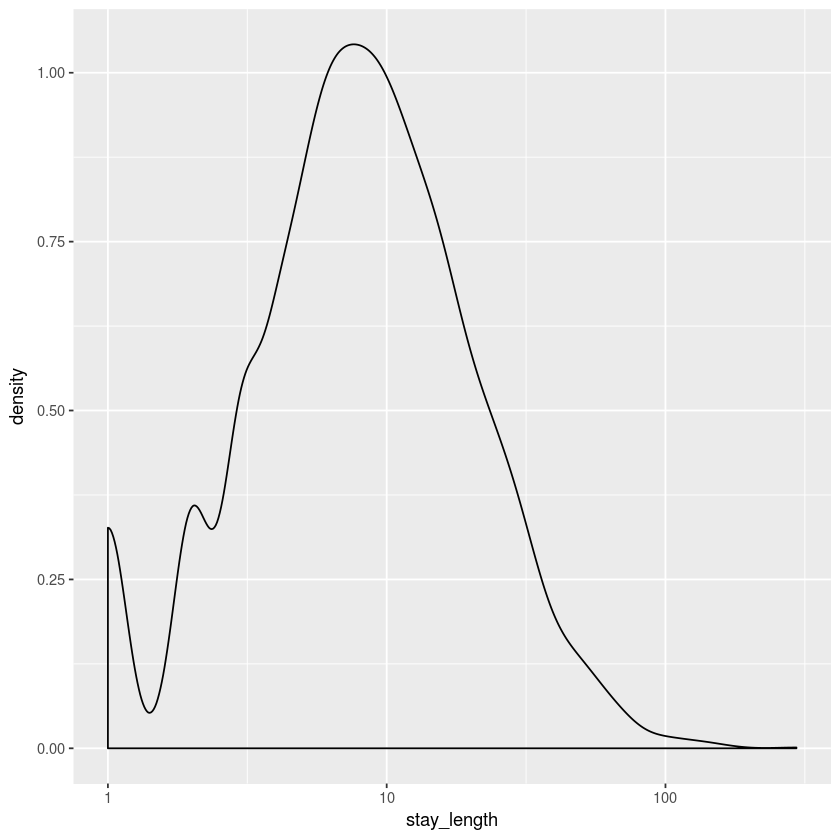

In [42]:
ggplot(data=admissions.tbl, aes(x=stay_length)) + 
    geom_density() + 
    scale_x_log10()

The warning means that there were stays with zero duration.  
That should not happen ... 
**Any ideas?**

In [43]:
# Pause for discussion























admissions.tbl %>% count(stay_length) %>% head()

stay_length,n
0,87
1,272
2,286
3,370
4,361
5,366


The admit and discharge have been truncated to the day, so a value of zero means that it is less than 1 day.

In [44]:
admissions.tbl %>%
    count(subject_id) %>%
    summarise( min    = min     (n)
             , median = median  (n)
             , mean   = mean    (n)
             , Q_75   = quantile(n, 0.75, names=F)
             , max    = max     (n)
             ) %>%
    gather(metric, value, everything())

metric,value
min,1.000000
median,1.000000
mean,1.283907
Q_75,1.000000
max,33.000000


In [45]:
admissions.tbl %>%
    count(subject_id) %>% count(n)

n,nn
1,3242
2,516
3,114
4,35
5,20
6,13
7,4
8,2
9,3
12,1


## Exercises

> Check the remainder of the tables for possible problems in the data.


In [46]:
























# inserted for space